In [23]:
import os
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from langchain.agents import create_agent
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import add_messages
from langgraph.graph import StateGraph, START, END
# from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from langchain_community.utilities import SQLDatabase
from langgraph.prebuilt import ToolNode

In [2]:
gemini_api_key = os.getenv('GOOGLE_API_KEY')

In [3]:
class FilterSummaryState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]
    input: str
    sql_query: str


In [4]:
uri = 'sqlite:///test.sqlite'
db = SQLDatabase.from_uri(uri)

In [5]:
llm = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash',
    temperature = 0
)

In [6]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

In [7]:
[(tool.name, tool.description) for tool in tools]

[('sql_db_query',
  "Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields."),
 ('sql_db_schema',
  'Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3'),
 ('sql_db_list_tables',
  'Input is an empty string, output is a comma-separated list of tables in the database.'),
 ('sql_db_query_checker',
  'Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!')]

In [8]:
input_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a helpful SQL assistant. You have access to a set of tools.

You must always use the tools to answer the user's question. Follow these steps:
1. Use the 'list_tables' tool to see what tables are available.
2. Use the 'get_schema' tool to understand the schema of the relevant tables.
3. Use the 'sql_db_query' tool to construct and run a SQL query.
4. If a query is bad, use 'sql_db_query_checker' to check it.
5. Finally, respond to the user with the answer."""
        ),

        MessagesPlaceholder(variable_name="messages"),

        # This will take the latest user input.
        ("human", "{input}"),
    ]
)

In [9]:
class Docs(BaseModel):
    docs: str = Field(description='Combined string of all the retrieved results')

In [10]:
structured_model = input_prompt_template | llm.bind_tools(tools=tools)

In [11]:
# sql_agent = create_agent(model=structured_model, state_schema=FilterSummaryState)

In [18]:
def call_llm(state: FilterSummaryState):

    messages = state['messages']
    input = state['input']

    res = structured_model.invoke(
        {
            'input': input,
            'messages': messages,
        }
    )

    return {
        'messages': res,
    }

def structured_llm(state: FilterSummaryState):

    last_message = state['messages'][-1]

    output_model = structured_model.with_structured_output(Docs)
    res = output_model.invoke(
        {
            'input': last_message.content,
        }
    )

    return {
        'messages': AIMessage(content=res.docs)
    }

call_tools = ToolNode(tools)

def is_tool_call(state: FilterSummaryState)->Literal[True, False]:

    last_message = state['messages'][-1]
    if len(last_message.tool_calls)>0:
        return True
    else:
        return False

In [19]:
graph = StateGraph(FilterSummaryState)
graph.add_node('call_llm', call_llm)
graph.add_node('call_tools', call_tools)
graph.add_node('get_output', structured_llm)

graph.add_edge(START, 'call_llm')
graph.add_edge('call_tools', 'call_llm')
graph.add_conditional_edges('call_llm', is_tool_call, {
    True: 'call_tools',
    False: 'get_output',
})

agent = graph.compile()

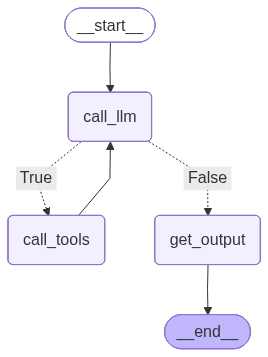

In [14]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())

In [20]:
user_input = "Insert into news the following values: ticker: NVDA, stock_name: Nvidia, content: Nothing happened for Nvidia this week"

In [36]:
for res in agent.stream(
    {
        'input': user_input,
        'messages': HumanMessage(content=user_input),
    },
    stream_mode='updates'
):

    for step, data in res.items():
            print(f"step: {step}")
            print(f"content: {data['messages']}")

step: call_llm
content: content='' additional_kwargs={'function_call': {'name': 'sql_db_list_tables', 'arguments': '{}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--4ca9a36d-1188-45b9-85a3-aeeeb84646ed-0' tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '984058fa-bdf7-4881-84c2-726a6b14c833', 'type': 'tool_call'}] usage_metadata={'input_tokens': 563, 'output_tokens': 131, 'total_tokens': 694, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 117}}
step: call_tools
content: [ToolMessage(content='news', name='sql_db_list_tables', id='a33257cd-5ccd-46d6-8537-143b4a99a172', tool_call_id='984058fa-bdf7-4881-84c2-726a6b14c833')]
step: call_llm
content: content='' additional_kwargs={'function_call': {'name': 'sql_db_schema', 'arguments': '{"table_names": "news"}'}

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 22.962432739s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  sec

step: call_llm
content: content='' additional_kwargs={'function_call': {'name': 'sql_db_list_tables', 'arguments': '{}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--6b6f2d01-79c6-4821-9206-7221e74d7ee3-0' tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '1f3dba07-4b3e-4cce-b1a4-c763be2b18f2', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1360, 'output_tokens': 326, 'total_tokens': 1686, 'input_token_details': {'cache_read': 745}, 'output_token_details': {'reasoning': 312}}
step: call_tools
content: [ToolMessage(content='news', name='sql_db_list_tables', id='c11d92d5-4e5f-4f3c-b149-eab8d425b8e7', tool_call_id='1f3dba07-4b3e-4cce-b1a4-c763be2b18f2')]
step: call_llm
content: content='' additional_kwargs={'function_call': {'name': 'sql_db_query_checker', 'arguments': '{"query": "INS

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT

In [18]:
res

AIMessage(content='', additional_kwargs={'function_call': {'name': 'sql_db_list_tables', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--a6bf8b0f-9498-4df8-898d-03b941c319cf-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'a4534ca2-1035-4c52-9793-dc4fd4d4fbfe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1195, 'output_tokens': 126, 'total_tokens': 1321, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 112}})